In [1]:
#Hello this the test file
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Rescaling,InputLayer, regularization
from keras.layers import Conv2D, MaxPool2D, Input
import matplotlib.pylab as plt
from tensorflow.python.client import device_lib
from keras.callbacks import CSVLogger
from keras.utils import plot_model
from keras.regularizers import l2 # ridge regression
from keras.regularizers import l1 # lasso regression
from keras.optimizers import Adam, SGD, RMSprop, Adamax
from keras import mixed_precision
import pandas as pd
import numpy as np
import os
import sys
from layers import BilinearInterpolation
from keras.layers import RandomFlip, RandomRotation, RandomZoom
import random as python_random


In [2]:

file_dir = os.path.realpath(os.path.dirname('__file__'))

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(device_lib.list_local_devices())


#GPU memory growth
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12172015182395513891
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1734816564
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6934124943257163365
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [3]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)


def convert_sample(sample):
    #alternativ use
    #image, label = sample['image'], sample['label']
    image = sample['image']
    label = sample['label']
    image = tf.image.convert_image_dtype(image, tf.float16)
    label =tf.one_hot(label, 2, dtype=tf.float16)
    return image, label

# print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# gpu_available = tf.test.is_gpu_available()

# is_cuda_gpu_available = tf.test.is_gpu_available(cuda_only=True)

# is_cuda_gpu_min_3 = tf.test.is_gpu_available(True, (3,0))

# device_lib.list_local_devices()
# print(tf. version) 

# print("if true, GPU lives: ",tf.test.is_built_with_cuda())

# tf.config.list_physical_devices('GPU')


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6


In [4]:
ds1,ds2,ds3 = tfds.load('patch_camelyon', split=['train[:20%]', 'test[:5%]', 'validation[:5%]'],
 data_dir = file_dir,
 shuffle_files = True,
 download = False)

In [5]:
tf.keras.backend.clear_session()
train_ds = ds1.map(convert_sample).batch(256)
test_ds = ds2.map(convert_sample).batch(256)
val_ds = ds3.map(convert_sample).batch(256)
#OBS JEG HAR ÆNDRET BATCH STØRRELSEN FRA 300 TIL 256

del ds1,ds2,ds3

In [6]:
# Create basic model
input_shape = (96, 96, 3)
num_classes = 2




def make_model(input_shape, num_classes):
    #Basic architecture of the CNN model
    model = Sequential()
    model.add(InputLayer(input_shape = input_shape))
    model.add(Conv2D(32, kernel_size = 3, activation='relu'))
    model.add(MaxPool2D(2,2))
    model.add(Conv2D(64, kernel_size = 3, activation='relu'))
    model.add(MaxPool2D(2,2))
    model.add(Conv2D(128, kernel_size = 3, activation='relu'))
    model.add(MaxPool2D(2,2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    #model = GlobalAveragePooling2D()(model)
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = 2

    model.add(Dense(units, activation = activation))
    Dropout
    return model


learning_rate = 0.001

adam_model = make_model(input_shape = input_shape, num_classes = 1)

adam_model.compile(
    optimizer = Adam(learning_rate = learning_rate),
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

SGD_model = make_model(input_shape = input_shape, num_classes = 1)

SGD_model.compile(
    optimizer= SGD(learning_rate = learning_rate),
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

adamax_model = make_model(input_shape = input_shape, num_classes = 1)

adamax_model.compile(
    optimizer = Adamax(learning_rate = learning_rate), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

RMSProp_model = make_model(input_shape = input_shape, num_classes = 1)

RMSProp_model.compile(
    optimizer = RMSprop(learning_rate = learning_rate),
    loss='categorical_crossentropy', 
    metrics=['accuracy'])    

In [7]:
# Create dataframe for storing results

df_all_acc = pd.DataFrame()

In [ ]:
# Adam optimizer
tf.keras.backend.clear_session()

history_adam = adam_model.fit(train_ds, epochs=30, validation_data=val_ds)
tf.keras.models.save_model(adam_model, file_dir+'\\Vanilla_Adam_CONV',save_format='tf',
include_optimizer=True)

df_all_acc['adam_accuracy'] = history_adam.history['accuracy']
df_all_acc['adam_val_accuracy'] = history_adam.history['val_accuracy']
df_all_acc['adam_loss'] = history_adam.history['loss']
df_all_acc['adam_val_loss'] = history_adam.history['val_loss']

del adam_model, history_adam


In [ ]:
# sigmoid optimizer
tf.keras.backend.clear_session()
history_SGD = SGD_model.fit(train_ds, epochs=30, validation_data=val_ds)
tf.keras.models.save_model(SGD_model, file_dir +'\\Vanilla_SGD_CONV',save_format='tf',
include_optimizer=True)

df_all_acc['SGD_accuracy'] = history_SGD.history['accuracy']
df_all_acc['SGD_val_accuracy'] = history_SGD.history['val_accuracy']
df_all_acc['SGD_loss'] = history_SGD.history['loss']
df_all_acc['SGD_val_loss'] = history_SGD.history['val_loss']

del SGD_model, history_SGD


In [ ]:
# adamax optimizer
tf.keras.backend.clear_session()
history_adamax = adamax_model.fit(train_ds, epochs=30, validation_data=val_ds)
tf.keras.models.save_model(adamax_model, file_dir+'\\Vanilla_adamax_CONV',save_format='tf',
include_optimizer=True)

df_all_acc['adamax_accuracy'] = history_adamax.history['accuracy']
df_all_acc['adamax_val_accuracy'] = history_adamax.history['val_accuracy']
df_all_acc['adamax_loss'] = history_adamax.history['loss']
df_all_acc['adamax_val_loss'] = history_adamax.history['val_loss']


del adamax_model, history_adamax


In [ ]:
# RMSProp optimizer
tf.keras.backend.clear_session()
history_RMSProp = RMSProp_model.fit(train_ds, epochs=30, validation_data=val_ds)
tf.keras.models.save_model(RMSProp_model, file_dir + '\\Vanilla_RMSProp_CONV',save_format='tf',
include_optimizer=True)

df_all_acc['RMSProp_accuracy'] = history_RMSProp.history['accuracy']
df_all_acc['RMSProp_val_accuracy'] = history_RMSProp.history['val_accuracy']
df_all_acc['RMSProp_loss'] = history_RMSProp.history['loss']
df_all_acc['RMSProp_val_loss'] = history_RMSProp.history['val_loss']


del RMSProp_model, history_RMSProp


In [21]:
adam_model = tf.keras.models.load_model(file_dir +'\\Vanilla_Adam_CONV')
SGD_model = tf.keras.models.load_model(file_dir +'\\Vanilla_SGD_CONV')
adamax_model = tf.keras.models.load_model(file_dir +'\\Vanilla_adamax_CONV')
RMSProp_model = tf.keras.models.load_model(file_dir +'\\Vanilla_RMSProp_CONV')


# vanilla_model = tf.keras.models.load_model(r'C:\Users\mikae\Anvendt maskinelearing eksamen\Vanilla_CONV')


models = pd.DataFrame({
    'Model': ['adam_model', 'SGD_model', 'adamax_model', 'RMSProp_model'],
    'Score': [adam_model.evaluate(test_ds), SGD_model.evaluate(test_ds), adamax_model.evaluate(test_ds), RMSProp_model.evaluate(test_ds)]})
    
print(models.sort_values(by='Score', ascending=False))#create dataframer for our models to compare their accuracy


7/7 [==============================] - 0s 25ms/step - loss: 1.1659 - accuracy: 0.7546
           Model                                     Score
0     adam_model  [1.7634572982788086, 0.7570207715034485]
3  RMSProp_model   [1.165928602218628, 0.7545787692070007]
2   adamax_model  [0.7088060975074768, 0.7771672606468201]
1      SGD_model  [0.5152022838592529, 0.7411477565765381]


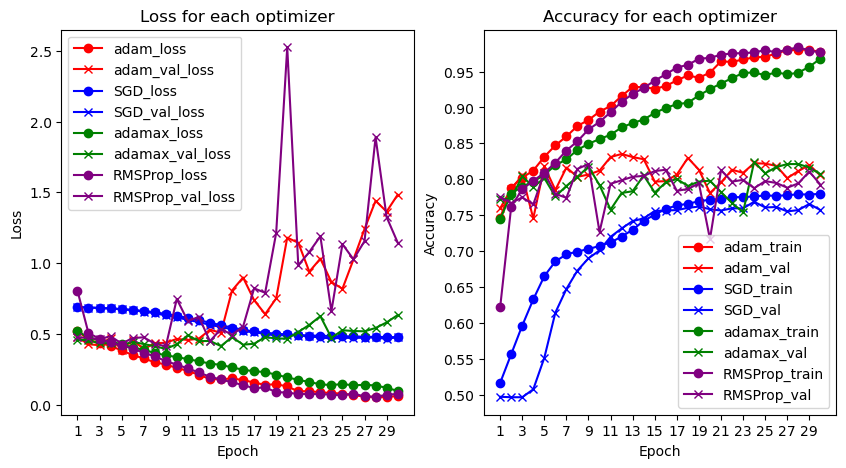

In [17]:
df_all_acc.to_csv(file_dir + '\\acc_loss_each_optimizer.csv', index = False)

# set index to 1 instead of 0 in the dataframe
# df_all_acc.index = df_all_acc.index + 1


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(df_all_acc['adam_loss'], marker = 'o', color = 'red')
plt.plot(df_all_acc['adam_val_loss'], marker = 'x', color = 'red')
plt.plot(df_all_acc['SGD_loss'], marker = 'o', color = 'blue')
plt.plot(df_all_acc['SGD_val_loss'], marker = 'x', color = 'blue')
plt.plot(df_all_acc['adamax_loss'], marker = 'o', color = 'green')
plt.plot(df_all_acc['adamax_val_loss'], marker = 'x', color = 'green')
plt.plot(df_all_acc['RMSProp_loss'], marker = 'o', color = 'purple')
plt.plot(df_all_acc['RMSProp_val_loss'], marker = 'x', color = 'purple')
plt.title('Loss for each optimizer')
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.xticks(np.arange(1, 30, 2))
plt.legend(['adam_loss', 'adam_val_loss', 'SGD_loss', 'SGD_val_loss', 'adamax_loss', 'adamax_val_loss', 'RMSProp_loss', 'RMSProp_val_loss'], loc='upper left')


#plot the validation accuracy and epochs for each model
plt.subplot(1, 2, 2)
plt.plot(df_all_acc['adam_accuracy'], marker = 'o', color = 'red')
plt.plot(df_all_acc['adam_val_accuracy'], marker = 'x', color = 'red')
plt.plot(df_all_acc['SGD_accuracy'], marker = 'o', color = 'blue')
plt.plot(df_all_acc['SGD_val_accuracy'], marker = 'x', color = 'blue')
plt.plot(df_all_acc['adamax_accuracy'], marker = 'o', color = 'green')
plt.plot(df_all_acc['adamax_val_accuracy'], marker = 'x', color = 'green')
plt.plot(df_all_acc['RMSProp_accuracy'], marker = 'o', color = 'purple')
plt.plot(df_all_acc['RMSProp_val_accuracy'], marker = 'x', color = 'purple')
plt.title('Accuracy for each optimizer')
plt.ylabel('Accuracy')
# tick marks for y axis
plt.yticks(np.arange(0.5, 1, 0.05))
plt.xlabel('Epoch') #tick marks for each epoch (1-20)
plt.xticks(np.arange(1, 30, 2) )
plt.legend(['adam_train', 'adam_val', 'SGD_train', 'SGD_val', 'adamax_train', 'adamax_val', 'RMSProp_train', 'RMSProp_val'], loc='lower right')
plt.show()



In [14]:
#base model with best optimizer with regularization and dropout


tf.keras.backend.clear_session()
input_shape = (96, 96, 3)

def regularized_adam_model(input_shape, num_classes, weight_regularizer, dropout_value):
    #Basic architecture of the CNN model
    model = Sequential(name='regularized_adam_model')
    model.add(InputLayer(input_shape = input_shape))
    model.add(Conv2D(32, kernel_size = 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))
    model.add(Dropout(dropout_value))
    #layer two
    model.add(Conv2D(64, kernel_size = 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))
    model.add(Dropout(dropout_value))


    #layer three
    model.add(Conv2D(128, kernel_size = 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))
    model.add(Dropout(dropout_value))

    #layer four
    model.add(Flatten())
    model.add(Dropout(dropout_value))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    #model = GlobalAveragePooling2D()(model)
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = 2

    model.add(Dense(units, activation = activation, kernel_regularizer = weight_regularizer))
    model.compile(
        optimizer= Adam(learning_rate=0.001),
        loss = 'categorical_crossentropy',
        metrics = ['accuracy']
    )
    return model


df_all_acc = pd.DataFrame()


In [ ]:
tf.keras.backend.clear_session()
regu_l2_model = regularized_adam_model(input_shape = input_shape, num_classes = 1,
 weight_regularizer = l2(0.01), dropout_value = 0.2)

history_regu_l2 = regu_l2_model.fit(train_ds, epochs=30, validation_data=val_ds)

tf.keras.models.save_model(regu_l2_model, file_dir+'\\Regu_l2_CONV',
 save_format='tf', include_optimizer=True)

df_all_acc['regu_l2_accuracy'] = history_regu_l2.history['accuracy']
df_all_acc['regu_l2_val_accuracy'] = history_regu_l2.history['val_accuracy']
df_all_acc['regu_l2_loss'] = history_regu_l2.history['loss']
df_all_acc['regu_l2_val_loss'] = history_regu_l2.history['val_loss']


del regu_l2_model, history_regu_l2


In [15]:
#Create summary of regu_l1 model   
regu_l1_model = regularized_adam_model(input_shape = input_shape, num_classes = 1,
    weight_regularizer = l1(0.01), dropout_value = 0.2)

regu_l1_model.summary()

Model: "regularized_adam_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 94, 94, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 47, 47, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 45, 45,

In [8]:
tf.keras.backend.clear_session()
regu_l1_model = regularized_adam_model(input_shape = input_shape, num_classes = 1,
    weight_regularizer = l1(0.01), dropout_value = 0.2)

history_regu_l1 = regu_l1_model.fit(train_ds, epochs=30, validation_data=val_ds)

tf.keras.models.save_model(regu_l1_model, file_dir+'\\Regu_l1_CONV',
    save_format='tf', include_optimizer=True)

df_all_acc['regu_l1_accuracy'] = history_regu_l1.history['accuracy']
df_all_acc['regu_l1_val_accuracy'] = history_regu_l1.history['val_accuracy']
df_all_acc['regu_l1_loss'] = history_regu_l1.history['loss']
df_all_acc['regu_l1_val_loss'] = history_regu_l1.history['val_loss']

df_all_acc.to_csv(file_dir+'\\regu_l1_and_l2_model.csv', index = False)

del regu_l1_model, history_regu_l1

Epoch 1/30
205/205 [==============================] - 25s 113ms/step - loss: 0.7492 - accuracy: 0.7855 - val_loss: 4.6337 - val_accuracy: 0.5043
Epoch 2/30
205/205 [==============================] - 23s 112ms/step - loss: 0.4957 - accuracy: 0.8314 - val_loss: 0.8780 - val_accuracy: 0.7210
Epoch 3/30
205/205 [==============================] - 23s 114ms/step - loss: 0.4183 - accuracy: 0.8453 - val_loss: 0.7027 - val_accuracy: 0.7790
Epoch 4/30
205/205 [==============================] - 23s 114ms/step - loss: 0.3749 - accuracy: 0.8604 - val_loss: 1.2109 - val_accuracy: 0.6935
Epoch 5/30
205/205 [==============================] - 23s 113ms/step - loss: 0.3427 - accuracy: 0.8714 - val_loss: 1.1681 - val_accuracy: 0.6880
Epoch 6/30
205/205 [==============================] - 23s 113ms/step - loss: 0.3177 - accuracy: 0.8826 - val_loss: 1.2270 - val_accuracy: 0.6862
Epoch 7/30
205/205 [==============================] - 24s 114ms/step - loss: 0.2982 - accuracy: 0.8895 - val_loss: 0.4761 - val_ac

INFO:tensorflow:Assets written to: C:\Users\mikae\Anvendt maskinelearing eksamen\Regu_l1_CONV\assets


INFO:tensorflow:Assets written to: C:\Users\mikae\Anvendt maskinelearing eksamen\Regu_l1_CONV\assets


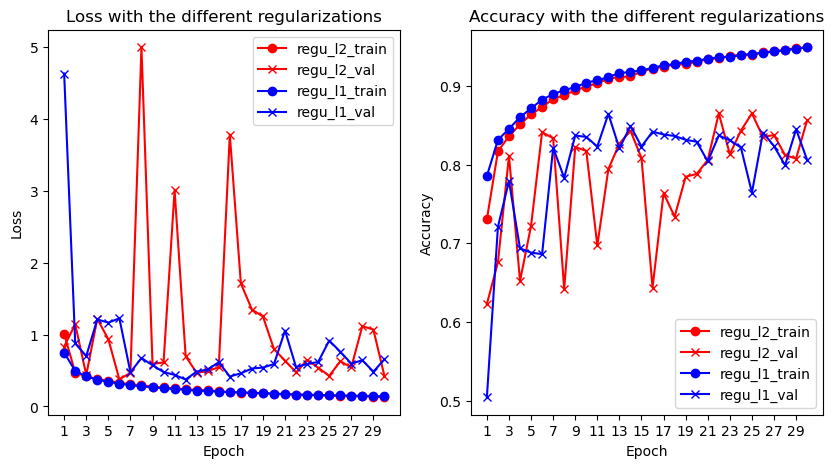

In [11]:
#save dataframe to csv
df_all_acc = pd.read_csv(file_dir+'\\regu_l1_and_l2_model.csv')

#set the index to start at 1
df_all_acc.index = df_all_acc.index + 1

# plt plot of the accuracy and loss from the training and validation data
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(df_all_acc['regu_l2_loss'], marker = 'o', color = 'red')
plt.plot(df_all_acc['regu_l2_val_loss'], marker = 'x', color = 'red')
plt.plot(df_all_acc['regu_l1_loss'], marker = 'o', color = 'blue')
plt.plot(df_all_acc['regu_l1_val_loss'], marker = 'x', color = 'blue')
plt.title('Loss with the different regularizations')
plt.ylabel('Loss')
plt.xlabel('Epoch') #tick marks for each epoch (1-30)
plt.xticks(np.arange(1, 30, 2))
plt.legend(['regu_l2_train', 'regu_l2_val', 'regu_l1_train', 'regu_l1_val'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(df_all_acc['regu_l2_accuracy'], marker = 'o', color = 'red')
plt.plot(df_all_acc['regu_l2_val_accuracy'], marker = 'x', color = 'red')
plt.plot(df_all_acc['regu_l1_accuracy'], marker = 'o', color = 'blue')
plt.plot(df_all_acc['regu_l1_val_accuracy'], marker = 'x', color = 'blue')
plt.title('Accuracy with the different regularizations')
plt.ylabel('Accuracy')
plt.xlabel('Epoch') #tick marks for each epoch (1-30)
plt.xticks(np.arange(1, 30, 2))
plt.legend(['regu_l2_train', 'regu_l2_val', 'regu_l1_train', 'regu_l1_val'], loc='lower right')
plt.show()


In [20]:
#load the regularized models and evaluate them
regu_l2_model = tf.keras.models.load_model(file_dir+'\\Regu_l2_CONV')
regu_l1_model = tf.keras.models.load_model(file_dir+'\\Regu_l1_CONV')

#get validations scores from regu_l1_mode


print(f'Regularized model with L2 accuracy {round(regu_l2_model.evaluate(test_ds)[1]*100,2)}%')
#Regularized model with L2 accuracy 74.3%
print(f'Regularized model with L1 accuracy {round(regu_l1_model.evaluate(test_ds)[1]*100,2)}%')
#Regularized model with L1 accuracy 79.55%

#load the regularized models and evaluate them on validation data


print(f'Regularized model with L2 accuracy {round(regu_l2_model.evaluate(val_ds)[1]*100,2)}%')

print(f'Regularized model with L1 accuracy {round(regu_l1_model.evaluate(val_ds)[1]*100,2)}%')

7/7 [==============================] - 7s 36ms/step - loss: 1.1358 - accuracy: 0.7430
Regularized model with L2 accuracy 74.3%
7/7 [==============================] - 0s 30ms/step - loss: 0.7436 - accuracy: 0.7955
Regularized model with L1 accuracy 79.55%
7/7 [==============================] - 0s 32ms/step - loss: 0.4261 - accuracy: 0.8565
Regularized model with L2 accuracy 85.65%
7/7 [==============================] - 0s 28ms/step - loss: 0.6564 - accuracy: 0.8059
Regularized model with L1 accuracy 80.59%


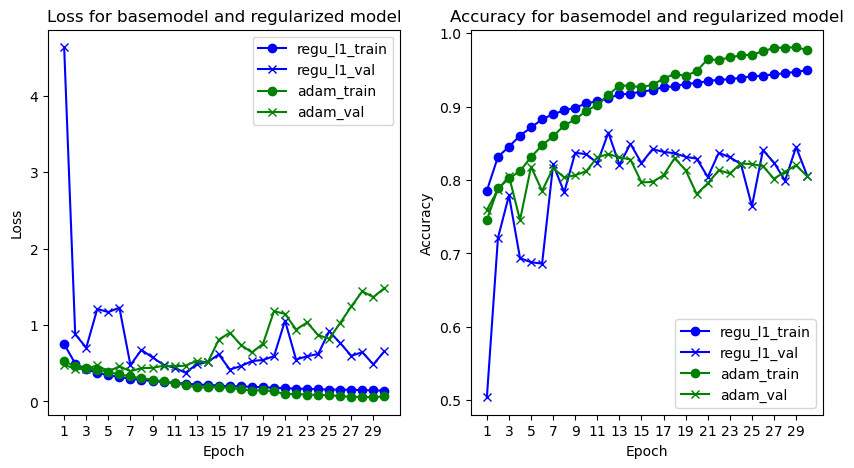

In [15]:
#Plotting the regularized model with L1 and the base model with adam optimizer
df_all_acc_regu = pd.read_csv(file_dir+'\\regu_l1_and_l2_model.csv')
df_all_acc_diff_opt = pd.read_csv(file_dir + '\\acc_loss_each_optimizer.csv')

#set the index to start at 1
df_all_acc_regu.index = df_all_acc_regu.index + 1
df_all_acc_diff_opt.index = df_all_acc_diff_opt.index + 1

#plot loss from both models
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(df_all_acc_regu['regu_l1_loss'], marker = 'o', color = 'blue')
plt.plot(df_all_acc_regu['regu_l1_val_loss'], marker = 'x', color = 'blue')
plt.plot(df_all_acc_diff_opt['adam_loss'], marker = 'o', color = 'green')
plt.plot(df_all_acc_diff_opt['adam_val_loss'], marker = 'x', color = 'green')
plt.title('Loss for basemodel and regularized model')
plt.ylabel('Loss')
plt.xlabel('Epoch') #tick marks for each epoch (1-30)
plt.xticks(np.arange(1, 30, 2))
plt.legend(['regu_l1_train', 'regu_l1_val', 'adam_train', 'adam_val'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(df_all_acc_regu['regu_l1_accuracy'], marker = 'o', color = 'blue')
plt.plot(df_all_acc_regu['regu_l1_val_accuracy'], marker = 'x', color = 'blue')
plt.plot(df_all_acc_diff_opt['adam_accuracy'], marker = 'o', color = 'green')
plt.plot(df_all_acc_diff_opt['adam_val_accuracy'], marker = 'x', color = 'green')
plt.title('Accuracy for basemodel and regularized model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch') #tick marks for each epoch (1-30)
plt.xticks(np.arange(1, 30, 2))
plt.legend(['regu_l1_train', 'regu_l1_val', 'adam_train', 'adam_val'], loc='lower right')
plt.show()

In [6]:
tf.keras.backend.clear_session()

input_shape = (96, 96, 3)


def regularized_augmented_model(input_shape, num_classes, weight_regularizer, dropout_value,**data_augmentation):
    #Basic architecture of the CNN model
    model = Sequential()
    model.add(RandomFlip("horizontal_and_vertical", input_shape=input_shape))
    model.add(RandomRotation(0.1))
    # model.add(data_augmentation)
    model.add(InputLayer(input_shape = input_shape))

    model.add(Conv2D(32, kernel_size = 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))
    model.add(Dropout(dropout_value))
    #layer two
    model.add(Conv2D(64, kernel_size = 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))
    model.add(Dropout(dropout_value))


    #layer three
    model.add(Conv2D(128, kernel_size = 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))
    model.add(Dropout(dropout_value))

    #layer four
    model.add(Flatten())
    model.add(Dropout(dropout_value))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    #model = GlobalAveragePooling2D()(model)
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = 2

    model.add(Dense(units, activation = activation, kernel_regularizer = weight_regularizer))
    model.compile(
        optimizer= Adam(learning_rate=0.001),
        loss = 'categorical_crossentropy',
        metrics = ['accuracy']
    )
    return model

In [ ]:
#Traing the model with the augmented data and the L1 regularization

tf.keras.backend.clear_session()
regu_l1_augmented_model = regularized_augmented_model(input_shape = input_shape, num_classes = 1,
    weight_regularizer = l1(0.01), dropout_value = 0.2)

history_regu_augmented_l1 = regu_l1_augmented_model.fit(train_ds, epochs=30, validation_data=val_ds)

tf.keras.models.save_model(regu_l1_augmented_model, file_dir+'\\data_augmentation_30',
    save_format='tf', include_optimizer=True)

df_all_acc = pd.DataFrame()

df_all_acc['regu_l1_augmented_accuracy'] = history_regu_augmented_l1.history['accuracy']
df_all_acc['regu_l1_augmented_val_accuracy'] = history_regu_augmented_l1.history['val_accuracy']
df_all_acc['regu_l1_augmented_loss'] = history_regu_augmented_l1.history['loss']
df_all_acc['regu_l1_augmented_val_loss'] = history_regu_augmented_l1.history['val_loss']

df_all_acc.to_csv(file_dir+'\\df_all_acc_regu_l1_augmented.csv', index=False)

del regu_l1_augmented_model, history_regu_augmented_l1

In [ ]:
#ONLY USE THIS FOR loading the model and continue training
tf.keras.backend.clear_session()
regu_l1_augmented_model = tf.keras.models.load_model(file_dir+'\\data_augmentation_30')

history_regu_augmented_l1 = regu_l1_augmented_model.fit(train_ds, epochs=20, validation_data=val_ds)

tf.keras.models.save_model(regu_l1_augmented_model, file_dir+'\\Regu_l1_augmented_CONV',
    save_format='tf', include_optimizer=True)

df_all_acc = pd.DataFrame()

df_all_acc['regu_l1_augmented_accuracy'] = history_regu_augmented_l1.history['accuracy']
df_all_acc['regu_l1_augmented_val_accuracy'] = history_regu_augmented_l1.history['val_accuracy']
df_all_acc['regu_l1_augmented_loss'] = history_regu_augmented_l1.history['loss']
df_all_acc['regu_l1_augmented_val_loss'] = history_regu_augmented_l1.history['val_loss']

df_all_acc.to_csv(file_dir+'\\df_all_acc_regu_l1_augmented.csv', index=False)

del regu_l1_augmented_model, history_regu_augmented_l1


In [ ]:
#load the a csv file to a dataframe
df_all_acc = pd.DataFrame()
df_all_acc = pd.read_csv(file_dir+'\\df_all_acc_regu_l1_augmented.csv')

#Setting the index of the dataframe to start from 1 instead of 0
df_all_acc.index = df_all_acc.index + 1



#Plot the validation and training accuracy and loss
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(df_all_acc['regu_l1_augmented_accuracy'], label='Training Accuracy')
plt.plot(df_all_acc['regu_l1_augmented_val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Accuracy regularized model with augmentation')
plt.xticks(np.arange(1,20,1))

plt.subplot(2, 1, 2)
plt.plot(df_all_acc['regu_l1_augmented_loss'], label='Training Loss')
plt.plot(df_all_acc['regu_l1_augmented_val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.3])
plt.title('Loss regularized model with augmentation')
plt.xlabel('epoch')
plt.xticks(np.arange(1,20,1))
plt.show()
